In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
import sklearn as sk 
from sklearn.model_selection import train_test_split

In [ ]:
# essa célula serve pra expandir as colunas/linhas do df.head(), assim consigo ver todo o split e entender melhor como ele tá separando
# pra voltar pra visualização padrão, só aplico o reset nele

pd.set_option("display.max_rows", None)  
pd.set_option("display.max_columns", None)  
pd.set_option("display.width", None) 
#pd.reset_option("display.max_rows")
#pd.reset_option("display.max_columns")
#pd.reset_option("display.width")

In [ ]:
import pandas as pd

df = pd.read_excel("Global_INT.xlsx", sheet_name="Global-INT")
dicti = ["continent_code",	"country_code",	"age",	"sex",	"gender_identity",	"sexual_orientation",	"height",	"weight",	"bmi",	"marital_status",	
         "student_accommodation",	"work",	"income_reportada_corrigida",	"income_categorias de renda pelo salário mínimo nacional_CLASSIFICAÇÃO",	
         "income_razão da renda pelo salário mínimo nacional",	"income_grupos de referência pelo percentil_20,40,60,80,100",	"score_food_smile",	
         "score_subs_smile",	"score_Physical Activity_smile",	"score_stress_smile",	"score_social_smile",	"score_sleep_smile",	"score_envir_smile",	
         "score_total_smile",	"sedentary_behavior",	'sedentary_2',	"gad7_score",	"gad7_severidade de sintomas"]

cat_var = ["continent_code", "country_code", "sex",	"gender_identity",	"sexual_orientation", "marital_status",	
           "student_accommodation",	"work", "income_grupos de referência pelo percentil_20,40,60,80,100", "gad7_severidade de sintomas",
           "sedentary_behavior",	'sedentary_2',]

num_var = ["age", "bmi", "score_food_smile", "score_subs_smile",	"score_Physical Activity_smile",	"score_stress_smile",	
           "score_social_smile",	"score_sleep_smile",	"score_envir_smile",	
           "score_total_smile", "gad7_score"]

df.drop(columns=["height", "weight", "income_reportada_corrigida",	
                 "income_categorias de renda pelo salário mínimo nacional_CLASSIFICAÇÃO",	
                 "income_razão da renda pelo salário mínimo nacional","income_reportada_corrigida",	
                 "income_categorias de renda pelo salário mínimo nacional_CLASSIFICAÇÃO"],
                 inplace = True)

for column in cat_var: 
    if not column == "gad7_severidade de sintomas": df[column] = df[column]-1

df.to_excel("Global_INT_15_02.xlsx", index = False)
print(df.head())

Separando os continentes

In [ ]:
import pandas as pd
#       separei os continentes em planilhas diferentes porque acho que assim conseguiria compartimentalizar
#       o código de forma melhor. também estou mais acostumado a trabalhar com as planilhas assim, já que
#       foi dessa forma que as utilizei na Fase 1
df = pd.read_excel("Global_INT_15_02.xlsx")

print("Columns found:", df.columns.tolist())
print("Data preview:\n", df.head())

if "continent_code" not in df.columns:
    raise ValueError("The column 'continent_code' was not found in the file. Please check the header name.")

try:
    df["continent_code"] = df["continent_code"].astype(int)
except Exception as e:
    print("Could not convert 'continent_code' to int:", e)

continent_mapping = {
    0: "América do Sul",
    1: "América do Norte",
    2: "Oceania",
    3: "Ásia",
    4: "África",
    5: "Europa"
}

for code, continent in continent_mapping.items():
    subset = df[df["continent_code"] == code]
    output_filename = f"{continent}_MODEL.xlsx"
    subset.to_excel(output_filename, index=False)
    print(f"Created {output_filename} with {len(subset)} rows.")


Definição das variáveis

In [5]:
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#AMÉRICA DO SUL

data = pd.read_excel("América do Sul_MODEL.xlsx", sheet_name='Sheet1')

cat_col_minus_oh = ["sex", "student_accommodation", "work", 
                    "income_grupos de referência pelo percentil_20,40,60,80,100",
                    "sedentary_behavior", 'sedentary_2']

one_hotted = ["marital_status", "gender_identity", "sexual_orientation", "country_code"]                
target_col = "gad7_severidade de sintomas"

data = data.drop(columns=["continent_code", "gad7_score", "score_total_smile"])

X = data.drop(columns=[target_col])
y = data[target_col]

missing_data_idx = X[X.isna().any(axis=1)].index.to_numpy()
complete_data_idx = X.dropna().index.to_numpy()


df = pd.DataFrame(data)
df.to_excel("América do Suil_MODEL_treated.xlsx", index=False)


<Axes: >

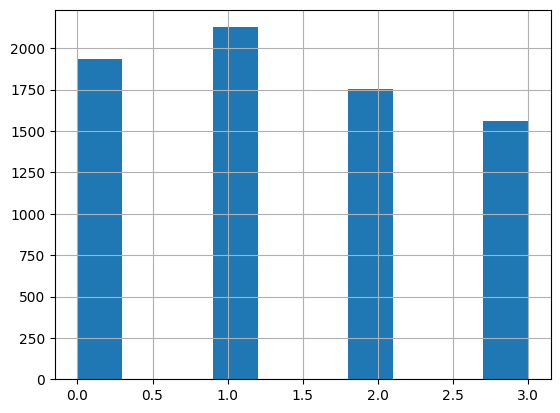

In [52]:
df[target_col].hist()

Tratando os splits - separando, codificando e escalonando

In [6]:
# separando os splits treino/teste (80/20)

import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
shuffle_split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=50)
splits = []

one_hotted = ["marital_status", "gender_identity", "sexual_orientation", "country_code", 'sex', 'student_accommodation', 'work']  

#cat_noh = ['sex', 'student_accommodation', 'work', 'sedentary_behavior','sedentary_2','income_grupos de referência pelo percentil_20,40,60,80,100']

num = ['age', 'bmi', 'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
       'score_stress_smile', 'score_social_smile', 'score_sleep_smile',
       'score_envir_smile',  'sedentary_behavior','sedentary_2',
       'income_grupos de referência pelo percentil_20,40,60,80,100']

for train_pos, test_pos in shuffle_split.split(complete_data_idx):
    train_idx = complete_data_idx[train_pos]
    test_idx = complete_data_idx[test_pos]

    train_idx = pd.Index(train_idx).union(missing_data_idx)  

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # One-hot encoding e StandardScaler
    onehot_transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    #scaler_transformer = MinMaxScaler(feature_range=(0, 1))
    scaler_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", onehot_transformer, one_hotted),
            ("scaler", scaler_transformer, num),
        ],
        remainder="passthrough"
    )

    #  codficando e escalonando
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    #nomeando as variáveis nos splits - melhor visualização
    onehot_names = preprocessor.named_transformers_["onehot"].get_feature_names_out(one_hotted)
    scaled_names = num

    remaining = [col for col in X_train.columns if col not in one_hotted + num]

    all_feature_names = np.concatenate([onehot_names, scaled_names, remaining])

    X_train = pd.DataFrame(X_train_transformed, index=X_train.index, columns=all_feature_names)
    X_test = pd.DataFrame(X_test_transformed, index=X_test.index, columns=all_feature_names)

    # guardando splits com os dados transformados
    splits.append({
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    })

inputed_splits = []
knn_imputer = KNNImputer(n_neighbors=5)
for split in splits: #iterando pelos splits
    
    X_train_inputed = pd.DataFrame(knn_imputer.fit_transform(split["X_train"]), 
                                   columns=split["X_train"].columns)
    inputed_splits.append(X_train_inputed)
# debugging: check do "transformer"
print(f"Treino: {splits[0]['X_train'].shape}, Teste: {splits[0]['X_test'].shape}")

#for split in splits:
#    count = split["X_train"]["age"].n
#        print(split["X_train"]["age"])

Treino: (6167, 42), Teste: (1210, 42)


In [ ]:
splits[3]['X_test'].describe()

In [ ]:
splits[3]['X_train'].describe()

Realizando a imputação

In [7]:
#após separados, escalonados e codificados, aplicar inputação de dados faltantes
#método k-Nearest Neighbour - nota: tentei aumentar e diminuir o n de vizinhos; pouca alteração
knn_imputer = KNNImputer(n_neighbors=1)
for split in splits:

    X_train_imputed = pd.DataFrame(
        knn_imputer.fit_transform(split["X_train"]),
        columns=split["X_train"].columns,
        index=split["X_train"].index
    )

    split["X_train_imputed"] = X_train_imputed

In [ ]:
splits[0]["X_train_imputed"].head()

In [ ]:
splits[1]["X_train_imputed"].head()

Testeando a similaridade dos dados inputados

In [8]:
c2 = ['marital_status_0.0', 'marital_status_1.0', 'marital_status_2.0',
       'marital_status_3.0', 'marital_status_4.0', 'marital_status_nan',
       'gender_identity_0.0', 'gender_identity_1.0', 'gender_identity_nan',
       'sexual_orientation_0.0', 'sexual_orientation_1.0',
       'sexual_orientation_2.0', 'sexual_orientation_3.0',
       'sexual_orientation_4.0', 'sexual_orientation_nan', 'country_code_0',
       'country_code_1', 'country_code_2', 'country_code_3', 'country_code_4',
       'country_code_5', "sex_0.0",	"sex_1.0",	"sex_nan",	"student_accommodation_0.0",	
       "student_accommodation_1.0",	"student_accommodation_nan",	"work_0.0",	"work_1.0",	"work_nan"] 

ks = ['age', 'bmi', 'income_grupos de referência pelo percentil_20,40,60,80,100', 
      'score_food_smile', 'score_subs_smile', 'score_Physical Activity_smile',
      'score_stress_smile', 'score_social_smile', 'score_sleep_smile',
      'score_envir_smile', 'sedentary_behavior','sedentary_2']

for i, split in enumerate(splits):

    X_train_imputed = splits[i]["X_train_imputed"]

    #testando a similaridade dos dados inputados vs originais
    for col in split["X_train"].columns:
        #teste KS para variáveis numéricas
        if col in ks:
            original_values = split["X_train"][col].dropna()
            imputed_values = X_train_imputed[col]

            ks_stat, p_value = ks_2samp(original_values, imputed_values)

            if p_value < 0.05: print(f"Variável {col}  NÃO tem distribuições similares (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} NÃO tem distribuições similares (proved null-hypothesis) - {p_value}")

        #chi-quadrado para testar variação entre categóricas
        elif col in c2:
            original_counts = split["X_train"][col].value_counts()
            imputed_counts = X_train_imputed[col].round().astype(int).value_counts()

            original_counts= original_counts.reindex(imputed_counts.index, fill_value=0)
            imputed_counts= imputed_counts.reindex(original_counts.index, fill_value=0)

            chi2, p_value, _, _ = chi2_contingency([original_counts, imputed_counts])

            if p_value < 0.05: print(f"Variável {col} AFETADA pela inputação (failed null-hypothesis) - {p_value}")
            #else: print(f"Variável {col} AFETADA pela inputação (proved null-hypothesis) - {p_value}")

Testando modelos

Separei as células dos "searchers" (Grid e Random) da célula com os modelos. 
Penso que a visualização fica melhor dessa forma

0.4206611570247934


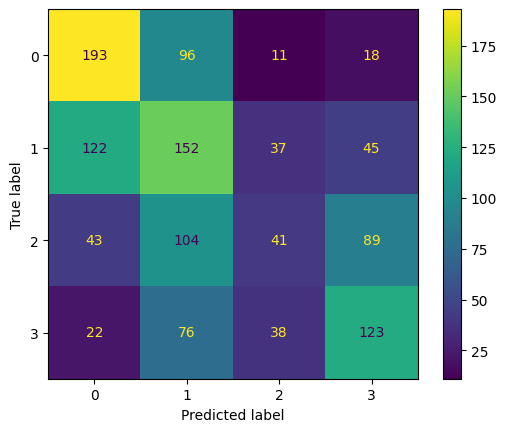

In [ ]:
#RandomForest

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

split = splits[0]

X_train = split['X_train_imputed']
X_test = split['X_test']
y_train = split['y_train']
y_test = split['y_test']

#   escrevi aqui os valores dos hiperparametros que utilizei, mais para guardar um histórico
#   GridSearch 1: (max_depth=10, min_samples_split=10, n_estimators=200) - 0.422

clf_rf = RandomForestClassifier(random_state=42, 
                                n_estimators=500,
                                max_depth=10,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_features='log2',
                                criterion='gini',
                                bootstrap=True)
clf_rf.fit(X_train, y_train)

predictions = clf_rf.predict(X_test)

acc = accuracy_score(y_test, predictions)
print(acc)

cm = confusion_matrix(y_test, predictions, labels=clf_rf.classes_)
mtx = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rf.classes_)
mtx.plot()
plt.show()

Algumas constantes nas ConfusionMatrix (posso mostrar as outras depois) são:
1. dificuldade de diferenciação entre 0 x 1 e 2 x 3
2. o modelo tende a "predizer pouco" a variável 2 - possivelmente tem dificuldade em diferenciar da 1 e da 3
Isso tanto para o RandomForest quanto para o SVM

In [ ]:
#GridSearch - RandomForest

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

split = splits[0]
X_train, y_train = split['X_train_imputed'], split['y_train']

pipeline = Pipeline([
    ('rf',  RandomForestClassifier())
])

param = {
    'rf__n_estimators': [50, 100, 200, 300, 500],
    'rf__max_depth': [None, 10, 20, 30, 50, 70],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy']
}

opt_params = GridSearchCV(
    pipeline,
    param_grid=param,
    scoring='accuracy',
    cv=10,
    verbose=0,
    n_jobs=-1,
)

opt_params.fit(X_train, y_train)
print("Parameters: ", opt_params.best_params_)
print("Estimators: ", opt_params.best_estimator_)
print("Melhor score: ",opt_params.best_score_)

0.41570247933884297


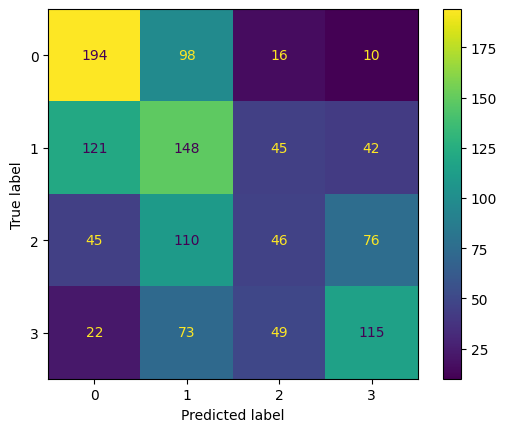

In [ ]:
#SVM 

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

split = splits[0]

X_train = split['X_train_imputed']
X_test = split['X_test']
y_train = split['y_train']
y_test = split['y_test']

#   escrevi aqui os valores dos hiperparametros que utilizei, mais para guardar um histórico

#   primeira grid search: 'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'} - 0.418
#   segunda grid search: 'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}, SVC balanced - 0.410
#   terceira grid search: 'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}, SVC balanced - 0.404
    
#   RandomSearch - 'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}, SVC  - 0.424
#   RandomSearch 2 - 'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, SVC - 0.415

clf_svm = SVC(random_state=42, kernel='rbf', gamma=0.001, C=100)
clf_svm.fit(X_train, y_train)

predictions = clf_svm.predict(X_test)

acc = accuracy_score(y_test, predictions)
print(acc)

cm = confusion_matrix(y_test, predictions, labels=clf_svm.classes_)
mtx = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=clf_svm.classes_)
mtx.plot()
plt.show()

In [ ]:
splits[0]["y_train"].hist()

In [ ]:
#GridSearchCV - SVM

from sklearn.pipeline import Pipeline

split = splits[0]
X_train, y_train = split['X_train_imputed'], split['y_train']

pipeline = Pipeline([
    ('svc',  SVC())
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000],
     'svc__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'svc__kernel': ['rbf', 'poly']
}

opt_params = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    verbose=0,
    n_jobs=-1 
)

opt_params.fit(X_train, y_train)
print("Parameters: ", opt_params.best_params_)
print("Estimators: ", opt_params.best_estimator_)
print("Melhor score: ",opt_params.best_score_)

In [ ]:
#RandomSearchCV - SVM

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

split = splits[0]
X_train, y_train = split['X_train_imputed'], split['y_train']

pipeline = Pipeline([
    ('svc',  SVC())
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000],
     'svc__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'svc__kernel': ['rbf', 'poly']
}

opt_params = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=10,
    verbose=0,
    random_state=42,
    n_jobs=-1 
)

opt_params.fit(X_train, y_train)
print("Parameters: ", opt_params.best_params_)
print("Estimators: ", opt_params.best_estimator_)
print("Melhor score: ",opt_params.best_score_)

Parameters:  {'svc__kernel': 'rbf', 'svc__gamma': 0.0001, 'svc__C': 100}
Estimators:  Pipeline(steps=[('svc', SVC(C=100, gamma=0.0001))])
Melhor score:  0.354925382559094


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

split = splits[0]
X_train, y_train = split['X_train_imputed'], split['y_train']

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {
    'objective': 'binary',
    'metric':'auc',
    'is_unbalance':'true',
    'boosting': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.01
}

model_lgbm = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data)

param_grid = {
    'objective': 'binary',
    'metric':'auc',
    'is_unbalance':'true',
    'boosting': 'gbdt',
    'num_leaves': randint(20, 50),
    'learning_rate': uniform(0.01, 0.1), 
    'n_estimators': randint(50, 200),
    'min_child_samples': randint(10, 50),
    'subsample': uniform(0.6, 0.4),      
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search = RandomizedSearchCV(
    estimator=lgb_regression,
    param_distributions=param_grid,
    n_iter=50,   
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
best_rmse = (-random_search.best_score_)**0.5
print("Best cross-validated RMSE:", best_rmse)

y_pred = random_search.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test set MSE:", test_mse)